In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
import mpl_toolkits.axes_grid1
import warnings
warnings.filterwarnings("ignore")

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pycocotools.coco import COCO
import seaborn as sns
import SaRa.saraRC1 as sara

In [3]:
feature_extractor_dict = {
    "VGG16": [
        tf.keras.applications.VGG16,
        tf.keras.applications.vgg16.preprocess_input,
        tf.keras.applications.vgg16.decode_predictions,
        (224, 224, 3)
    ],
    "ResNet50": [
        tf.keras.applications.ResNet50,
        tf.keras.applications.resnet50.preprocess_input,
        tf.keras.applications.resnet50.decode_predictions,
        (224, 224, 3)
    ],
    "InceptionV3": [
        tf.keras.applications.InceptionV3,
        tf.keras.applications.inception_v3.preprocess_input,
        tf.keras.applications.inception_v3.decode_predictions,
        (299, 299, 3)
    ],
    "Xception": [
        tf.keras.applications.Xception,
        tf.keras.applications.xception.preprocess_input,
        tf.keras.applications.xception.decode_predictions,
        (299, 299, 3)
    ],
    "EfficientNetB0": [
        tf.keras.applications.EfficientNetB0,
        tf.keras.applications.efficientnet.preprocess_input,
        tf.keras.applications.efficientnet.decode_predictions,
        (224, 224, 3)
    ],
}

model_name = "VGG16"
model_constructor, preprocess_input_fn, decode_predictions_fn, input_shape = feature_extractor_dict[model_name]

model = model_constructor(weights="imagenet", include_top=False)
model.trainable = False

# Removing dsize from input_shape
input_shape = input_shape[:-1]

batch_size = 128  # Define your batch size

In [4]:
generator = 'itti'
GRID_SIZE = 8

# Define COCO annotation file and data type
coco_version = "2017"  # Choose 2014 or 2017
data_type = "train"  # Choose "train" or "val"
annotation_file = f"./COCODataset/annotations/instances_{data_type}{coco_version}.json"

# Load COCO dataset and annotations
coco = COCO(annotation_file)
category_ids = coco.getCatIds()

# Class subset
subset_count = 500  # Number of images to use for each class subset

loading annotations into memory...
Done (t=10.50s)
creating index...
index created!


In [5]:
category_dict = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck',
    9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'stop sign', 13: 'parking meter', 14: 'bench',
    15: 'bird', 16: 'cat', 17: 'dog', 18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear',
    23: 'zebra', 24: 'giraffe', 25: 'backpack', 26: 'umbrella', 27: 'handbag', 28: 'tie', 29: 'suitcase',
    30: 'frisbee', 31: 'skis', 32: 'snowboard', 33: 'sports ball', 34: 'kite', 35: 'baseball bat',
    36: 'baseball glove', 37: 'skateboard', 38: 'surfboard', 39: 'tennis racket', 40: 'bottle',
    41: 'wine glass', 42: 'cup', 43: 'fork', 44: 'knife', 45: 'spoon', 46: 'bowl', 47: 'banana',
    48: 'apple', 49: 'sandwich', 50: 'orange', 51: 'broccoli', 52: 'carrot', 53: 'hot dog', 54: 'pizza',
    55: 'donut', 56: 'cake', 57: 'chair', 58: 'couch', 59: 'potted plant', 60: 'bed', 61: 'dining table',
    62: 'toilet', 63: 'tv', 64: 'laptop', 65: 'mouse', 66: 'remote', 67: 'keyboard', 68: 'cell phone',
    69: 'microwave', 70: 'oven', 71: 'toaster', 72: 'sink', 73: 'refrigerator', 74: 'book',
    75: 'clock', 76: 'vase', 77: 'scissors', 78: 'teddy bear', 79: 'hair drier', 80: 'toothbrush'
}

In [6]:
# Load VGG16 model using dictionary
model = model_constructor(weights='imagenet', include_top=True)

# Initialize lists to collect metrics for each class
precision_list1 = []
recall_list1 = []
accuracy_list1 = []
f1_list1 = []
total_true_labels1 = []
total_predicted_labels1 = []


# Accumulate images for batch prediction
batch_images = []

for category_id in category_ids:
    batch_images = []  # Reset batch images
    batch_true_labels1 = []  # Reset batch true labels
    batch_predicted_labels1 = []  # Reset batch predicted labels

    # Get category name
    category_info = coco.loadCats(category_id)[0]
    category_name = category_info['name']

    # Get image IDs containing the current category
    image_ids = coco.getImgIds(catIds=[category_id])

    for idx, image_id in enumerate(image_ids):
        if idx >= subset_count:
            break

        # Load and preprocess the image using VGG16 requirements
        image_info = coco.loadImgs(image_id)[0]
        path = f"./COCODataset/{data_type}{coco_version}/{image_info['file_name']}"
        image = cv2.imread(path)
        sara.reset()
        bgr_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, input_shape)  # Resize for VGG16 input
        image_for_vgg = np.expand_dims(image, axis=0)
        image_for_vgg = preprocess_input_fn(image_for_vgg)
        batch_images.append(image_for_vgg)

        if len(batch_images) >= subset_count:  # Check if accumulated images reach subset count
            break

    # # Process predictions for the entire batch
    # batch_images = np.vstack(batch_images)
    # batch_predictions = model.predict(batch_images)

    # # Decode predictions
    # decoded_predictions = decode_predictions_fn(batch_predictions)
    predictions = []

    for i in range(0, len(batch_images), batch_size):
        batch = batch_images[i:i+batch_size]
        batch = np.vstack(batch)
        batch_predictions = model.predict(batch)
        predictions.append(batch_predictions)

    # Flatten the list of batch predictions
    predictions = np.concatenate(predictions)


    # Decode predictions
    decoded_predictions = decode_predictions_fn(predictions)
    
    # Process decoded predictions for each image in the batch
    for i in range(len(decoded_predictions)):
        predicted_label = decoded_predictions[i][0][1]  # Get the predicted label
        true_label = category_name  # True label is the category name

        total_predicted_labels1.append(predicted_label)
        total_true_labels1.append(true_label)
        batch_true_labels1.append(true_label)
        batch_predicted_labels1.append(predicted_label)

    # Calculate metrics for the batch
    batch_classification_report = classification_report(batch_true_labels1, batch_predicted_labels1, output_dict=True)
    batch_precision = batch_classification_report['weighted avg']['precision']
    batch_recall = batch_classification_report['weighted avg']['recall']
    batch_accuracy = batch_classification_report['accuracy']
    batch_f1_score = batch_classification_report['weighted avg']['f1-score']

    # Append metrics to the lists
    precision_list1.append(batch_precision)
    recall_list1.append(batch_recall)
    accuracy_list1.append(batch_accuracy)
    f1_list1.append(batch_f1_score)
    

4/4 [==============================] - 0s 84ms/step


In [7]:
normal_classification_rep = classification_report(total_true_labels1, total_predicted_labels1, output_dict=True)
normal_precision = normal_classification_rep['weighted avg']['precision']
normal_recall = normal_classification_rep['weighted avg']['recall']
normal_f1_score = normal_classification_rep['weighted avg']['f1-score']
normal_accuracy = normal_classification_rep['accuracy']

print(f"Precision: {normal_precision}")
print(f"Recall: {normal_recall}")
print(f"F1 Score: {normal_f1_score}")
print(f"Accuracy: {normal_accuracy}")

Precision: 0.07075428638120065
Recall: 0.02459016393442623
F1 Score: 0.030276118068373215
Accuracy: 0.02459016393442623


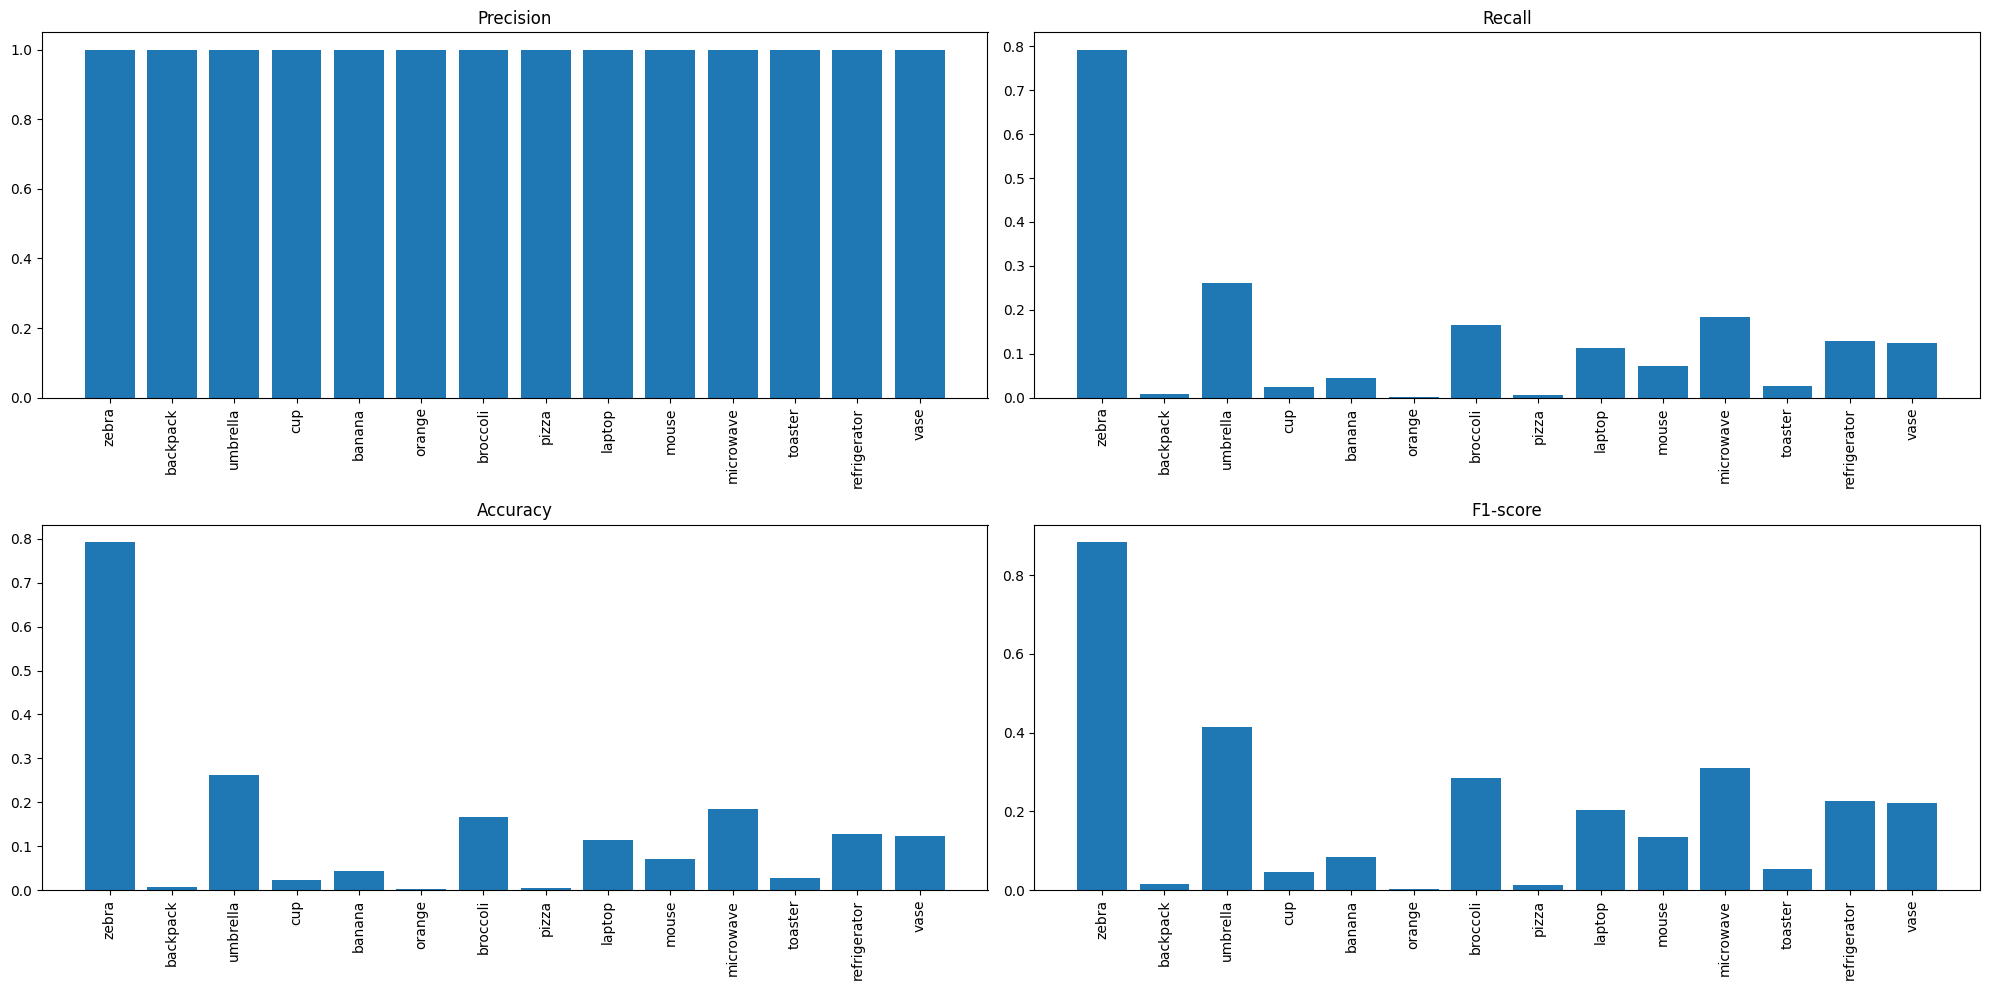

In [8]:
normal_non_zero_indices = [i for i, value in enumerate(precision_list1) if value != 0]

normal_non_zero_categories = [list(category_dict.values())[i] for i in normal_non_zero_indices]
normal_non_zero_precision = [precision_list1[i] for i in normal_non_zero_indices]
normal_non_zero_recall = [recall_list1[i] for i in normal_non_zero_indices]
normal_non_zero_accuracy = [accuracy_list1[i] for i in normal_non_zero_indices]
normal_non_zero_f1 = [f1_list1[i] for i in normal_non_zero_indices]

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.bar(normal_non_zero_categories, normal_non_zero_precision)
plt.xticks(rotation=90)
plt.title('Precision')

plt.subplot(2, 2, 2)
plt.bar(normal_non_zero_categories, normal_non_zero_recall)
plt.xticks(rotation=90)
plt.title('Recall')

plt.subplot(2, 2, 3)
plt.bar(normal_non_zero_categories, normal_non_zero_accuracy)
plt.xticks(rotation=90)
plt.title('Accuracy')

plt.subplot(2, 2, 4)
plt.bar(normal_non_zero_categories, normal_non_zero_f1)
plt.xticks(rotation=90)
plt.title('F1-score')

plt.tight_layout()
plt.show()


In [9]:
del model

In [10]:
def resize_based_on_important_ranks(img, sara_info, grid_size, rate=0.9):
    def generate_segments(image, seg_count) -> dict:
        segments = {}
        segment_count = seg_count
        index = 0

        h, w = image.shape[:2]
        w_interval = w // segment_count
        h_interval = h // segment_count

        for i in range(segment_count):
            for j in range(segment_count):
                x1, y1 = j * w_interval, i * h_interval
                x2, y2 = x1 + w_interval, y1 + h_interval
                segments[index] = (x1, y1, x2, y2)
                index += 1

        return segments

    sara_dict = {
        info[0]: {
            'score': info[2],
            'index': info[1]
        }
        for info in sara_info[1]
    }

    sorted_sara_dict = sorted(sara_dict.items(), key=lambda item: item[1]['score'], reverse=True)

    index_info = generate_segments(img, grid_size)

    most_imp_ranks = np.zeros_like(img)

    max_rank = int(grid_size * grid_size * rate)
    count = 0

    for rank, info in sorted_sara_dict:
        if count < max_rank:
            coords = index_info[info['index']]
            most_imp_ranks[coords[1]:coords[3], coords[0]:coords[2]] = 255
            count += 1
        else:
            break

    coords = np.argwhere(most_imp_ranks == 255)
    if coords.size == 0:
        return img

    x0, y0 = coords.min(axis=0)[:2]
    x1, y1 = coords.max(axis=0)[:2] + 1
    cropped_img = img[x0:x1, y0:y1]
    return cropped_img


In [11]:
# Load VGG16 model using dictionary
model = model_constructor(weights='imagenet', include_top=True)

# Initialize lists to collect metrics for each class
precision_list2 = []
recall_list2 = []
accuracy_list2 = []
f1_list2 = []
total_true_labels2 = []
total_predicted_labels2 = []


# Accumulate images for batch prediction
batch_images = []

for category_id in category_ids:
    batch_images = []  # Reset batch images
    batch_true_labels2 = []  # Reset batch true labels
    batch_predicted_labels2 = []  # Reset batch predicted labels

    # Get category name
    category_info = coco.loadCats(category_id)[0]
    category_name = category_info['name']

    # Get image IDs containing the current category
    image_ids = coco.getImgIds(catIds=[category_id])

    for idx, image_id in enumerate(image_ids):
        if idx >= subset_count:
            break

        # Load and preprocess the image using VGG16 requirements
        image_info = coco.loadImgs(image_id)[0]
        path = f"./COCODataset/{data_type}{coco_version}/{image_info['file_name']}"
        image = cv2.imread(path)
        sara.reset()
        bgr_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        sara.reset()
        bgr_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        sara_info = sara.return_sara(bgr_img, GRID_SIZE, generator, mode=2)
        cropped_img = resize_based_on_important_ranks(bgr_img, sara_info, GRID_SIZE)
        # Applying Adaptive Histogram Equalization
        # # Convert BGR to RGB
        # image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

        # # Convert to grayscale for AHE processing
        # image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

        # # Create a CLAHE object (Contrast Limited Adaptive Histogram Equalization)
        # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Adjust parameters as needed

        # # Apply CLAHE to enhance the grayscale image
        # enhanced_image_gray = clahe.apply(image_gray)

        # # Convert the enhanced grayscale image back to RGB
        # enhanced_image_rgb = cv2.cvtColor(enhanced_image_gray, cv2.COLOR_GRAY2RGB)

        # image = enhanced_image_rgb
        image = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, input_shape)  # Resize for VGG16 input
        image_for_vgg = np.expand_dims(image, axis=0)
        image_for_vgg = preprocess_input_fn(image_for_vgg)
        batch_images.append(image_for_vgg)

        if len(batch_images) >= subset_count:  # Check if accumulated images reach subset count
            break

    # # Process predictions for the entire batch
    # batch_images = np.vstack(batch_images)

    predictions = []

    for i in range(0, len(batch_images), batch_size):
        batch = batch_images[i:i+batch_size]
        batch = np.vstack(batch)
        batch_predictions = model.predict(batch)
        predictions.append(batch_predictions)

    # Flatten the list of batch predictions
    predictions = np.concatenate(predictions)


    # Decode predictions
    decoded_predictions = decode_predictions_fn(predictions)

    # Process decoded predictions for each image in the batch
    for i in range(len(decoded_predictions)):
        predicted_label = decoded_predictions[i][0][1]  # Get the predicted label
        true_label = category_name  # True label is the category name

        total_predicted_labels2.append(predicted_label)
        total_true_labels2.append(true_label)
        batch_true_labels2.append(true_label)
        batch_predicted_labels2.append(predicted_label)

    # Calculate metrics for the batch
    batch_classification_report = classification_report(batch_true_labels2, batch_predicted_labels2, output_dict=True)
    batch_precision = batch_classification_report['weighted avg']['precision']
    batch_recall = batch_classification_report['weighted avg']['recall']
    batch_accuracy = batch_classification_report['accuracy']
    batch_f1_score = batch_classification_report['weighted avg']['f1-score']

    # Append metrics to the lists
    precision_list2.append(batch_precision)
    recall_list2.append(batch_recall)
    accuracy_list2.append(batch_accuracy)
    f1_list2.append(batch_f1_score)

4/4 [==============================] - 0s 51ms/step


In [12]:
sara_classification_rep = classification_report(total_true_labels2, total_predicted_labels2, output_dict=True)
sara_precision = sara_classification_rep['weighted avg']['precision']
sara_recall = sara_classification_rep['weighted avg']['recall']
sara_f1_score = sara_classification_rep['weighted avg']['f1-score']
sara_accuracy = sara_classification_rep['accuracy']

print(f"Precision: {sara_precision}")
print(f"Recall: {sara_recall}")
print(f"F1 Score: {sara_f1_score}")
print(f"Accuracy: {sara_accuracy}")

Precision: 0.07113927809348311
Recall: 0.02459016393442623
F1 Score: 0.030314953774481995
Accuracy: 0.02459016393442623


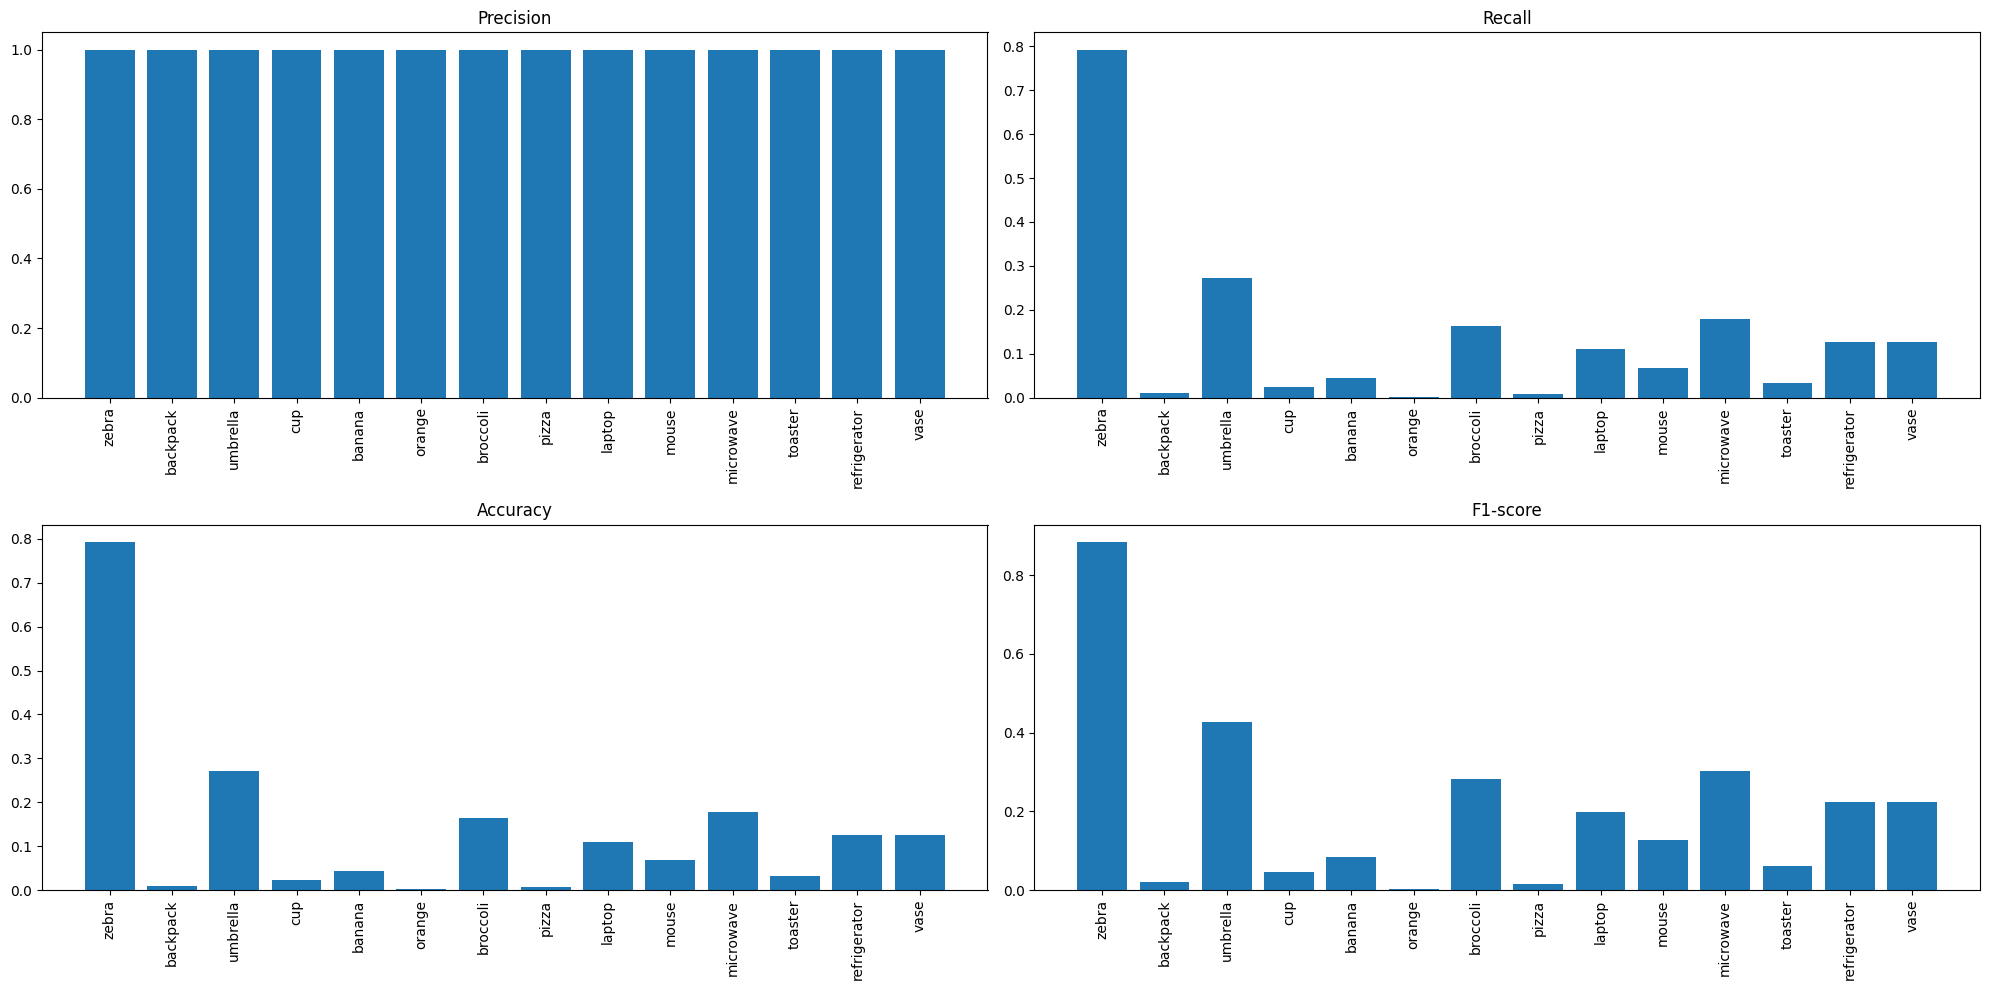

In [13]:
sara_non_zero_indices = [i for i, value in enumerate(precision_list2) if value != 0]

sara_non_zero_categories = [list(category_dict.values())[i] for i in sara_non_zero_indices]
sara_non_zero_precision = [precision_list2[i] for i in sara_non_zero_indices]
sara_non_zero_recall = [recall_list2[i] for i in sara_non_zero_indices]
sara_non_zero_accuracy = [accuracy_list2[i] for i in sara_non_zero_indices]
sara_non_zero_f1 = [f1_list2[i] for i in sara_non_zero_indices]

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.bar(sara_non_zero_categories, sara_non_zero_precision)
plt.xticks(rotation=90)
plt.title('Precision')

plt.subplot(2, 2, 2)
plt.bar(sara_non_zero_categories, sara_non_zero_recall)
plt.xticks(rotation=90)
plt.title('Recall')

plt.subplot(2, 2, 3)
plt.bar(sara_non_zero_categories, sara_non_zero_accuracy)
plt.xticks(rotation=90)
plt.title('Accuracy')

plt.subplot(2, 2, 4)
plt.bar(sara_non_zero_categories, sara_non_zero_f1)
plt.xticks(rotation=90)
plt.title('F1-score')

plt.tight_layout()
plt.show()


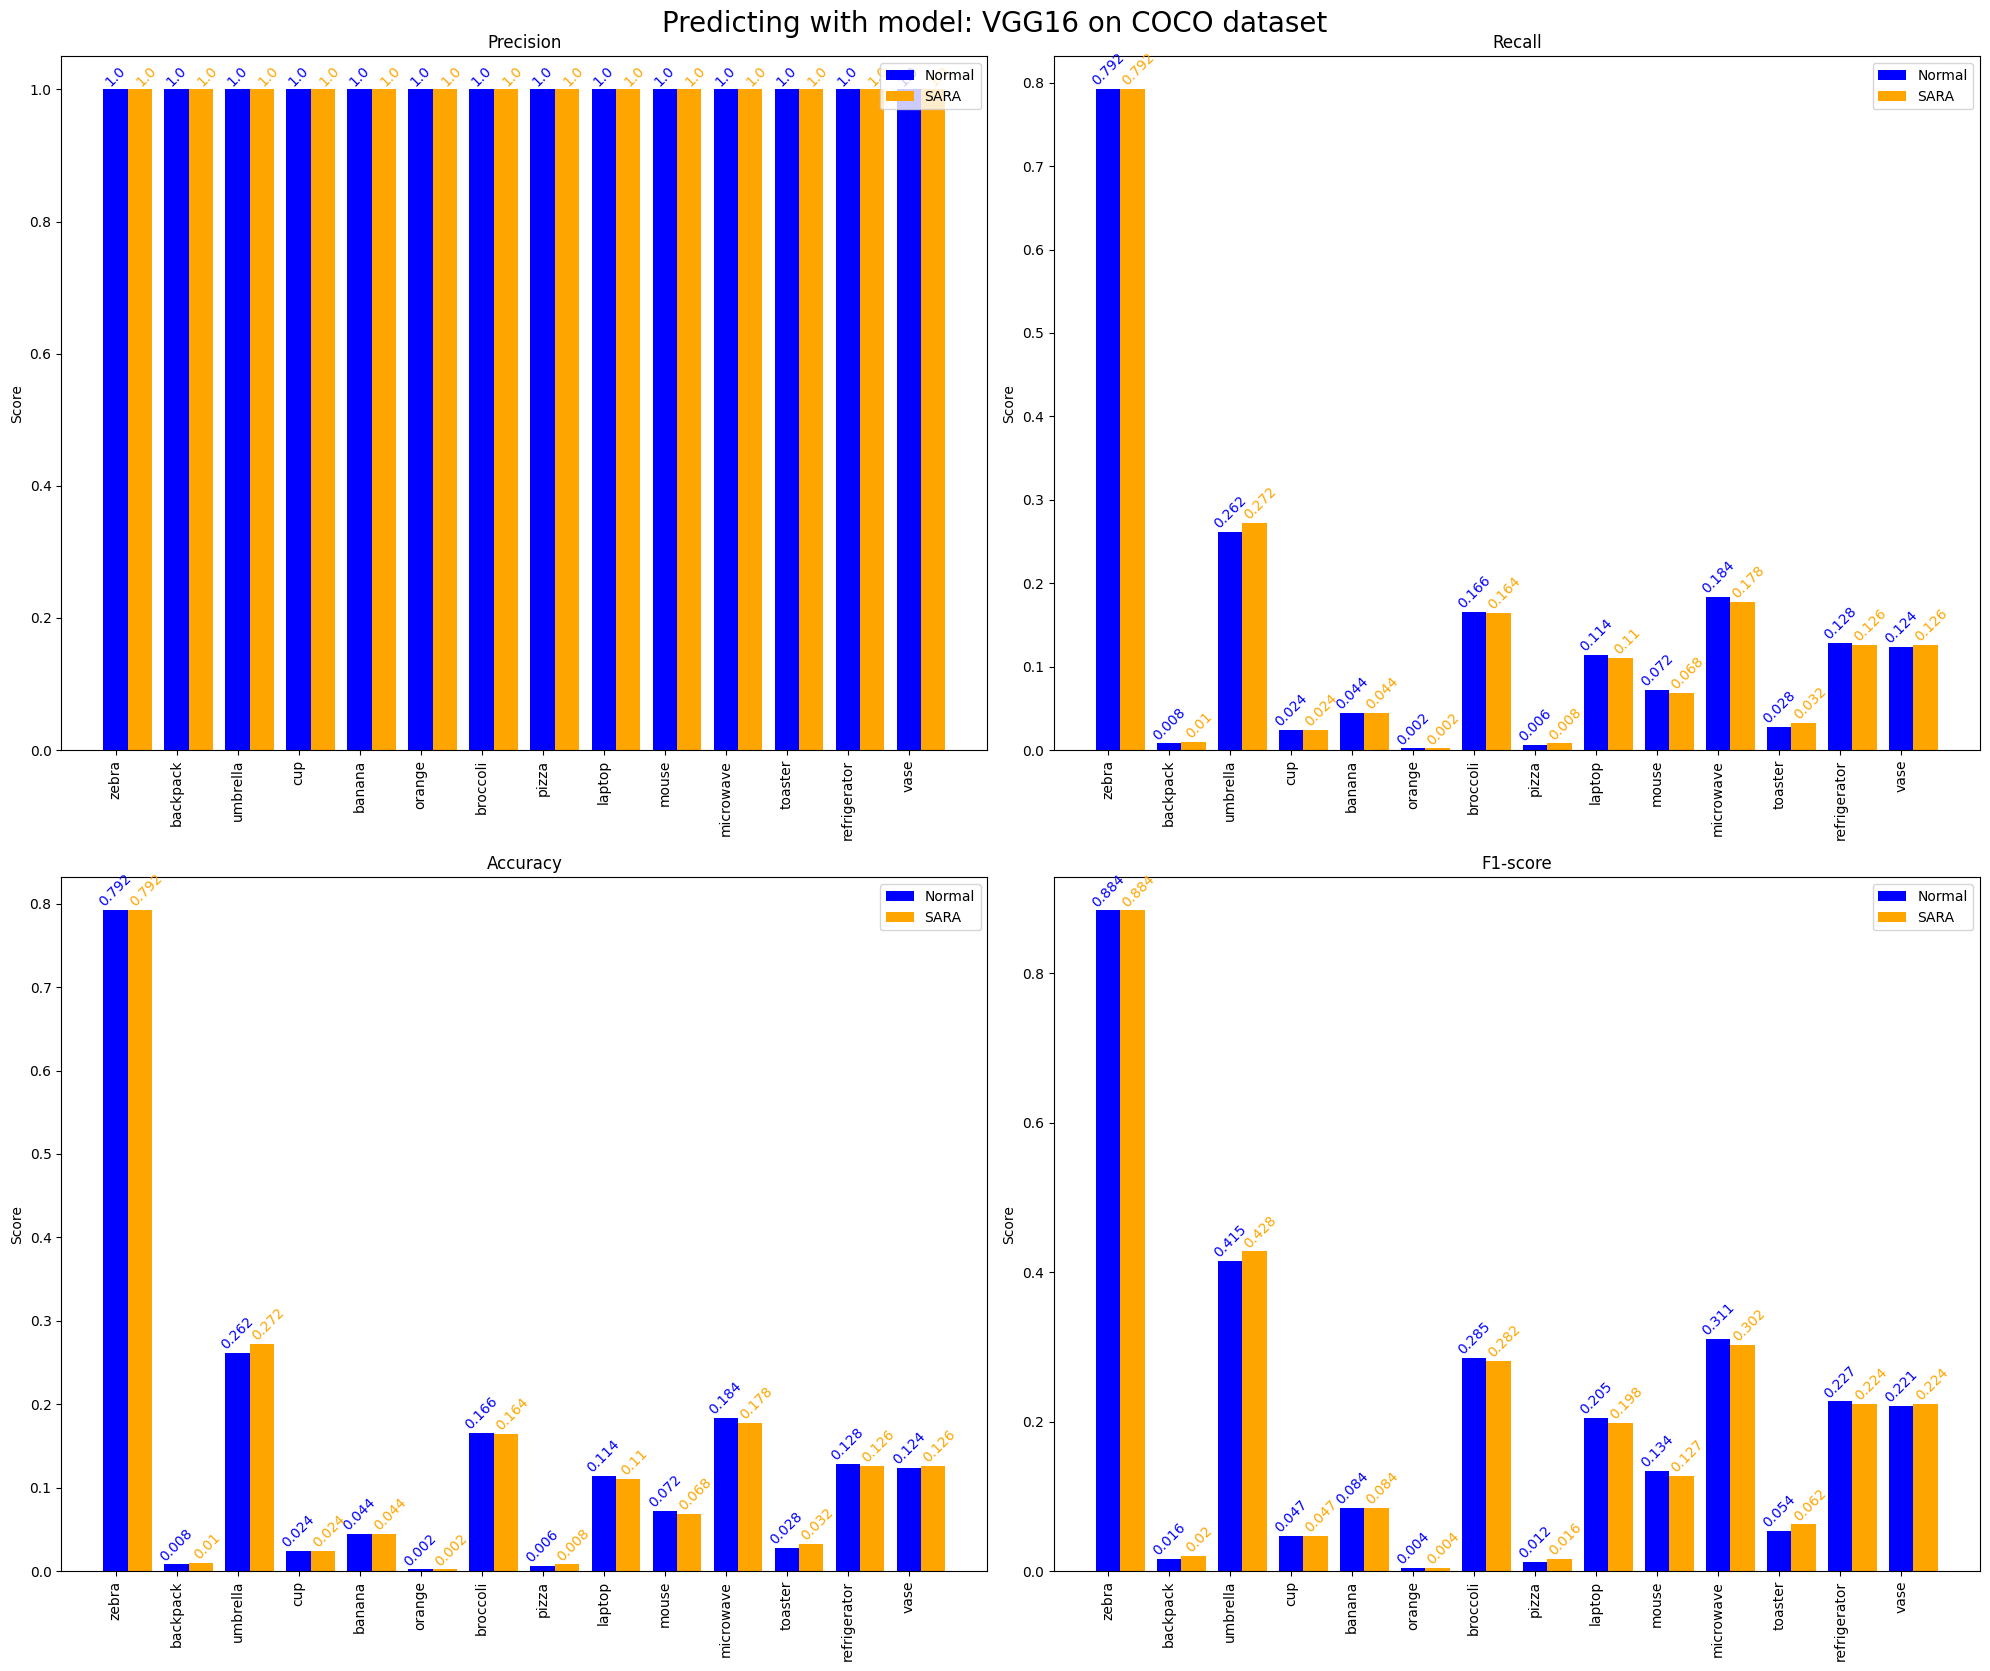

In [14]:
metrics = ['Precision', 'Recall', 'Accuracy', 'F1-score']
normal_metrics = [normal_non_zero_precision, normal_non_zero_recall, normal_non_zero_accuracy, normal_non_zero_f1]
sara_metrics = [sara_non_zero_precision, sara_non_zero_recall, sara_non_zero_accuracy, sara_non_zero_f1]
categories = [normal_non_zero_categories, normal_non_zero_categories, normal_non_zero_categories, normal_non_zero_categories]

plt.figure(figsize=(20, 17))

for i, metric in enumerate(metrics, start=1):
    plt.subplot(2, 2, i)
    x = range(len(normal_metrics[i-1]))
    plt.bar(x, normal_metrics[i-1], color='blue', width=0.4, align='center', label='Normal')
    # Adding text to the top of each bar
    for j, v in enumerate(normal_metrics[i-1]):
        plt.text(x[j], v + 0.001, str(round(v, 3)), color='blue', ha='center', va='bottom', rotation=45)
    plt.bar([pos + 0.4 for pos in x], sara_metrics[i-1], color='orange', width=0.4, align='center', label='SARA')
    # Adding text to the top of each bar
    for j, v in enumerate(sara_metrics[i-1]):
        plt.text(x[j] + 0.5, v + 0.001, str(round(v, 3)), color='orange', ha='center', va='bottom', rotation=45)
    plt.xticks(x, categories[i-1], rotation=90)
    plt.legend()
    plt.title(metric)
    plt.ylabel('Score')
    plt.tight_layout()

plt.suptitle('Predicting with model: ' + model_name+' on COCO dataset', fontsize=20)
plt.tight_layout()
plt.show()


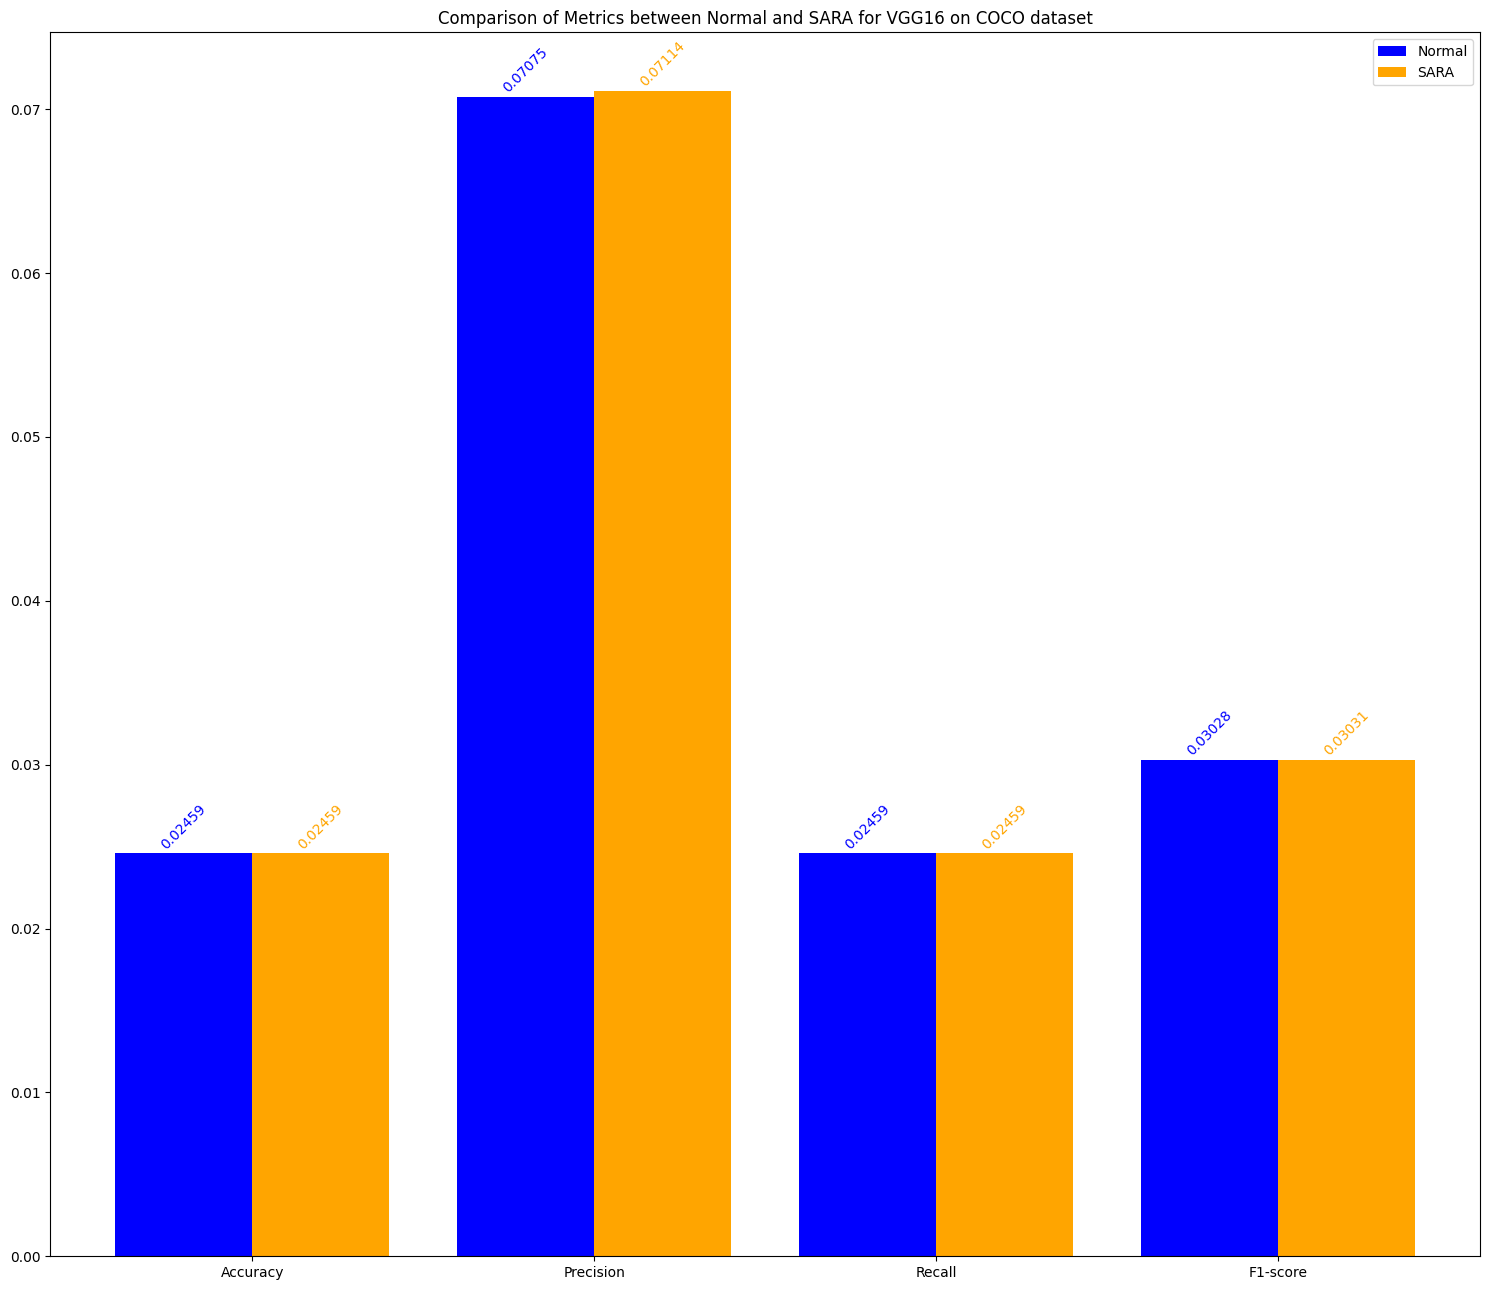

In [15]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
normal_metrics = [normal_accuracy, normal_precision, normal_recall, normal_f1_score]
sara_metrics = [sara_accuracy, sara_precision, sara_recall, sara_f1_score]

plt.figure(figsize=(15, 13))

x = range(len(metrics))

# Plotting each metric for "Normal" and "SARA"
for i, metric in enumerate(metrics):
    plt.bar(x[i] - 0.2, normal_metrics[i], color='blue', width=0.4, align='center')
    plt.bar(x[i] + 0.2, sara_metrics[i], color='orange', width=0.4, align='center')
    plt.text(x[i] - 0.2, normal_metrics[i] + 0.0001, round(normal_metrics[i], 5), ha='center', va='bottom', color='blue', rotation=45)
    plt.text(x[i] + 0.2, sara_metrics[i] + 0.0001, round(sara_metrics[i], 5), ha='center', va='bottom', color='orange', rotation=45)

plt.xticks(x, metrics)
plt.legend(['Normal', 'SARA'], loc='upper right')
plt.title('Comparison of Metrics between Normal and SARA for ' + model_name+' on COCO dataset')

plt.tight_layout()
plt.show()